# Entrenamiento de un Modelo de Deep Learning de Inicio a Fin




### ✅ 1. Cargar y visualizar el dataset


Utilizaremos MNIST o CIFAR-10 como datasets de ejemplo:

In [2]:



import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

print("Tamaño del set de entrenamiento:", len(train_data))
print("Tamaño del set de prueba:", len(test_data))



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.04MB/s]

Tamaño del set de entrenamiento: 60000
Tamaño del set de prueba: 10000


Visualizamos ejemplos:

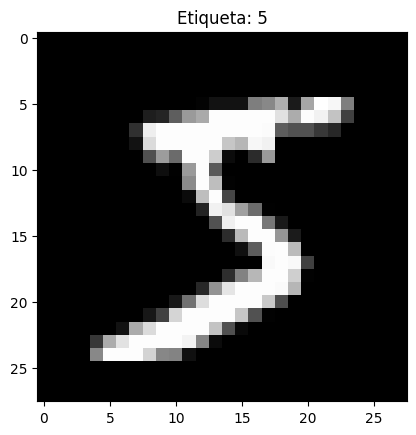

In [3]:

import matplotlib.pyplot as plt

image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Etiqueta: {label}")
plt.show()




### ✅ 2. Preparar los dataloaders

Dividimos entrenamiento y validación:

In [4]:


from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(train_data))
val_size   = len(train_data) - train_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)



### ✅ 3. Definir el modelo

Creamos una red simple para clasificación:

In [5]:

import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)



### ✅ 4. Configurar función de pérdida y optimizador

In [6]:


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




### ✅ 5. Entrenar el modelo

In [7]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {accuracy:.4f}")


Epoch 1/10, Train Loss: 0.4636, Val Loss: 0.2362, Val Accuracy: 0.9307
Epoch 2/10, Train Loss: 0.2356, Val Loss: 0.1803, Val Accuracy: 0.9459
Epoch 3/10, Train Loss: 0.1930, Val Loss: 0.1712, Val Accuracy: 0.9458
Epoch 4/10, Train Loss: 0.1675, Val Loss: 0.1389, Val Accuracy: 0.9586
Epoch 5/10, Train Loss: 0.1524, Val Loss: 0.1262, Val Accuracy: 0.9633
Epoch 6/10, Train Loss: 0.1393, Val Loss: 0.1247, Val Accuracy: 0.9609
Epoch 7/10, Train Loss: 0.1339, Val Loss: 0.1117, Val Accuracy: 0.9677
Epoch 8/10, Train Loss: 0.1200, Val Loss: 0.1218, Val Accuracy: 0.9645
Epoch 9/10, Train Loss: 0.1165, Val Loss: 0.1254, Val Accuracy: 0.9637
Epoch 10/10, Train Loss: 0.1101, Val Loss: 0.1033, Val Accuracy: 0.9712




### ✅ 6. Validación y evaluación del modelo

#### 📌 Validación estándar (hold-out)
Ya realizada en cada epoch con `val_loader`.

#### 📌 K-Fold Cross Validation

In [8]:


from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
X = torch.stack([train_data[i][0] for i in range(len(train_data))])
y = torch.tensor([train_data[i][1] for i in range(len(train_data))])




#### 📌 Métricas de evaluación

In [9]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu())
        all_labels.extend(labels)

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.99      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000




Visualización de la matriz de confusión:

<Axes: >

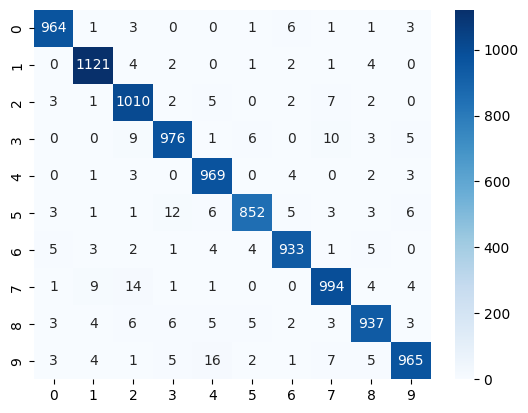

In [10]:

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')



### ✅ 7. Fine-Tuning con modelo preentrenado

Usamos `resnet18` como ejemplo:


In [11]:

from torchvision import models

model_ft = models.resnet18(pretrained=True)

# Congelar todas las capas
for param in model_ft.parameters():
    param.requires_grad = False

# Reemplazar capa final
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)  # 10 clases

model_ft.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


Entrenamiento:

In [12]:
optimizer = optim.Adam(model_ft.fc.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Entrenamiento similar al anterior pero solo con la capa final


Para un fine-tuning completo:


In [13]:

for param in model_ft.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_ft.parameters(), lr=1e-5)




Comparar resultados con y sin fine-tuning.



### ✅ 8. Guardar y reutilizar el modelo


In [14]:

torch.save(model.state_dict(), "modelo_final.pth")





Para cargarlo después:

In [15]:
model.load_state_dict(torch.load("modelo_final.pth"))
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
# Completar el entrenamiento del modelo fine-tuned
epochs_ft = 5  # Puedes ajustar este número
train_losses_ft, val_losses_ft = [], []

for epoch in range(epochs_ft):
    model_ft.train()
    running_loss_ft = 0
    for images, labels in train_loader:
        # Repeat the single channel 3 times to simulate RGB
        images = images.repeat(1, 3, 1, 1)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output_ft = model_ft(images)
        loss_ft = criterion(output_ft, labels)
        loss_ft.backward()
        optimizer.step()
        running_loss_ft += loss_ft.item()

    train_losses_ft.append(running_loss_ft / len(train_loader))

    # Validación del modelo fine-tuned
    model_ft.eval()
    val_loss_ft = 0
    correct_ft = 0
    total_ft = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Repeat the single channel 3 times to simulate RGB
            images = images.repeat(1, 3, 1, 1)
            images, labels = images.to(device), labels.to(device)
            output_ft = model_ft(images)
            val_loss_ft += criterion(output_ft, labels).item()
            _, predicted_ft = torch.max(output_ft.data, 1)
            total_ft += labels.size(0)
            correct_ft += (predicted_ft == labels).sum().item()

    val_losses_ft.append(val_loss_ft / len(val_loader))
    accuracy_ft = correct_ft / total_ft

    print(f"Fine-tuning Epoch {epoch+1}/{epochs_ft}, Train Loss: {train_losses_ft[-1]:.4f}, Val Loss: {val_losses_ft[-1]:.4f}, Val Accuracy: {accuracy_ft:.4f}")

Fine-tuning Epoch 1/5, Train Loss: 0.7330, Val Loss: 0.1611, Val Accuracy: 0.9574
Fine-tuning Epoch 2/5, Train Loss: 0.1417, Val Loss: 0.0767, Val Accuracy: 0.9777
Fine-tuning Epoch 3/5, Train Loss: 0.0863, Val Loss: 0.0546, Val Accuracy: 0.9848
Fine-tuning Epoch 4/5, Train Loss: 0.0581, Val Loss: 0.0467, Val Accuracy: 0.9866
Fine-tuning Epoch 5/5, Train Loss: 0.0450, Val Loss: 0.0422, Val Accuracy: 0.9882


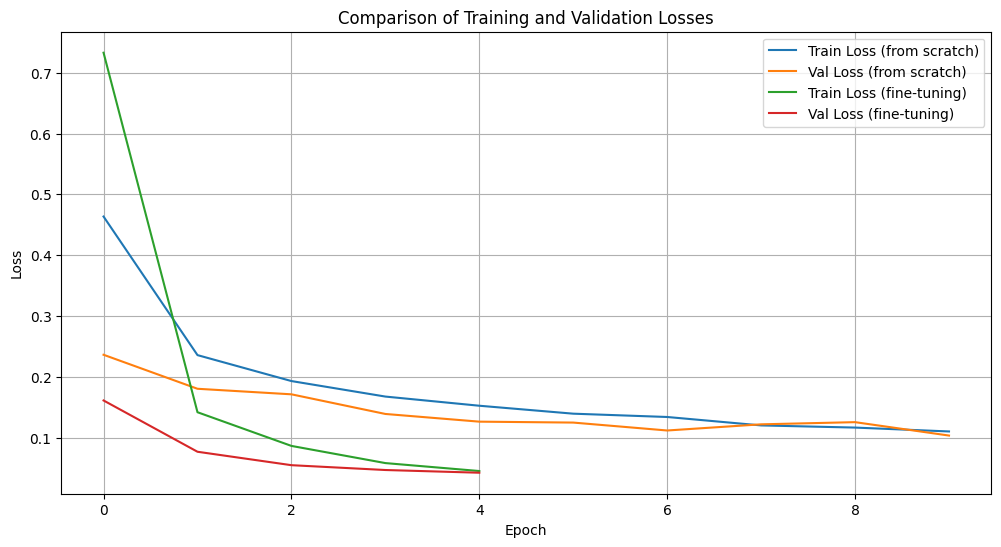

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss (from scratch)')
plt.plot(val_losses, label='Val Loss (from scratch)')
plt.plot(train_losses_ft, label='Train Loss (fine-tuning)')
plt.plot(val_losses_ft, label='Val Loss (fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()